## Inicialização 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Carregue os dados

O conjunto de dados é armazenado na pasta `/datasets/faces/`, onde você pode encontrar "
- A pasta `final_files` com 7,6k fotos "
- O arquivo `labels.csv` com rótulos, com duas colunas: `file_name` e `real_age` 

Dado que o número de arquivos de imagem é bastante alto, é aconselhável evitar a leitura de todos de uma vez, o que consumiria muito recursos computacionais. Recomendamos que você crie um gerador com o ImageDataGenerator. Este método foi explicado no Capítulo 3, Lição 7 deste curso.

O arquivo de rótulo pode ser carregado como um arquivo CSV normal.

In [2]:
#Carregando o arquivo com os Labels.
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
#Gerando as imagens com ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
features, target = next(train_gen_flow)
print(features[0])  

[[[0.5764706  0.5137255  0.454902  ]
  [0.53333336 0.47058827 0.41176474]
  [0.5294118  0.4666667  0.40784317]
  ...
  [0.48235297 0.4156863  0.30588236]
  [0.49411768 0.427451   0.31764707]
  [0.49803925 0.43137258 0.32156864]]

 [[0.5176471  0.454902   0.39607847]
  [0.5058824  0.4431373  0.38431376]
  [0.5529412  0.4901961  0.43137258]
  ...
  [0.49803925 0.43137258 0.32156864]
  [0.50980395 0.4431373  0.33333334]
  [0.50980395 0.4431373  0.33333334]]

 [[0.5176471  0.45098042 0.38823533]
  [0.5058824  0.43921572 0.37647063]
  [0.5176471  0.45098042 0.38823533]
  ...
  [0.5019608  0.43529415 0.3254902 ]
  [0.50980395 0.4431373  0.33333334]
  [0.5058824  0.43921572 0.32941177]]

 ...

 [[0.06666667 0.45882356 0.52156866]
  [0.08235294 0.47450984 0.5372549 ]
  [0.04705883 0.427451   0.49411768]
  ...
  [0.16078432 0.40784317 0.43529415]
  [0.12156864 0.36862746 0.39607847]
  [0.15294118 0.40000004 0.427451  ]]

 [[0.10196079 0.49411768 0.5568628 ]
  [0.06666667 0.45882356 0.52156866]


In [5]:
#Conferindo o shape das caracteristicas. 
features.shape

(32, 224, 224, 3)

Vemos que foram geradas 32 imagens com 224x224 pixels em 3 canais de cores.

## EDA

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Não temos valores nulos. Ao todo são 7591 imagens.

In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


A média de idade é 31,2 anos, mediana 29 anos. A idade mínima encontrada é 1 ano e a máxima 100.  

<AxesSubplot:>

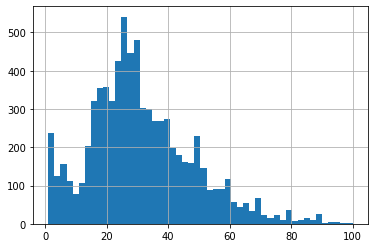

In [8]:
labels['real_age'].hist(bins=50)

Analisando o histograma vemos que a maioria das imagens são de pessoas entre 18 e 40 anos.

### Encontrando 

Idade 50


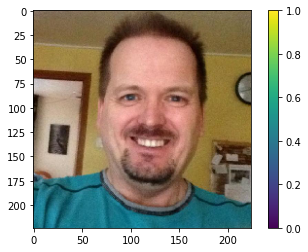

Idade 41


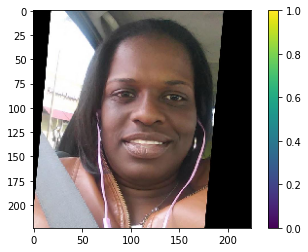

Idade 46


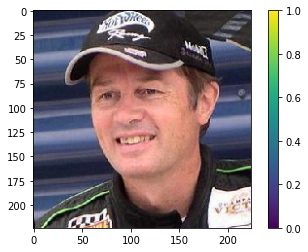

Idade 85


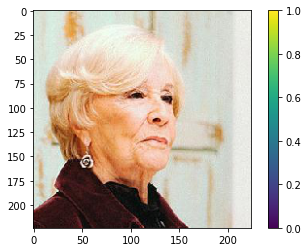

Idade 14


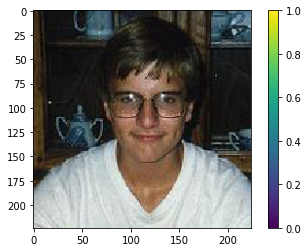

Idade 40


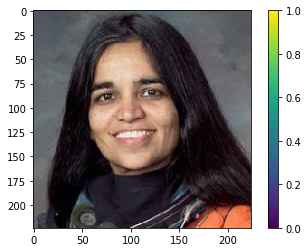

Idade 14


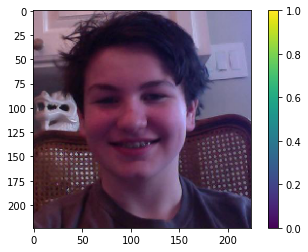

Idade 53


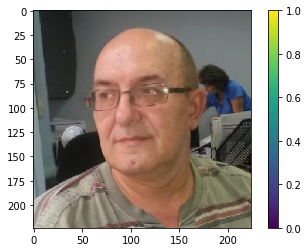

Idade 4


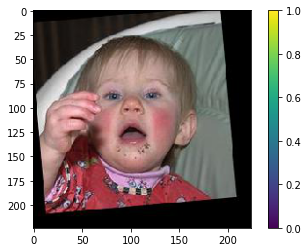

Idade 32


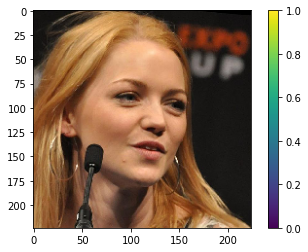

Idade 14


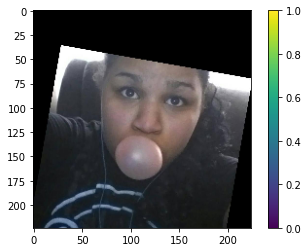

Idade 23


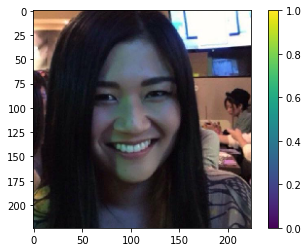

Idade 37


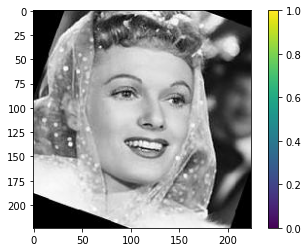

Idade 62


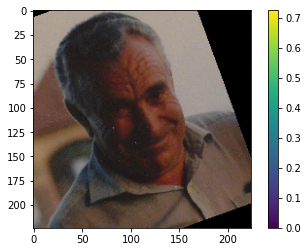

Idade 21


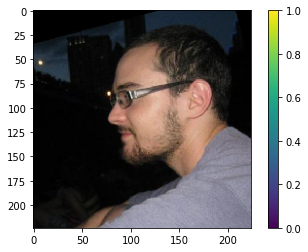

Idade 58


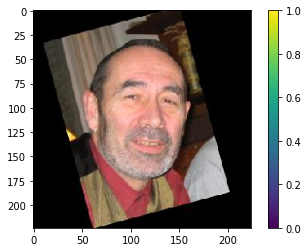

Idade 43


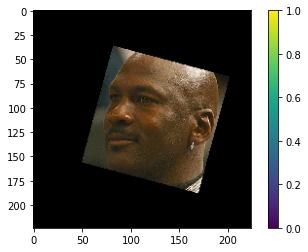

Idade 32


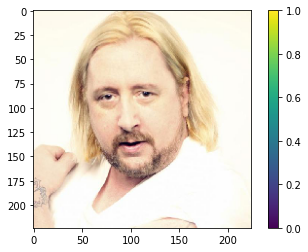

Idade 25


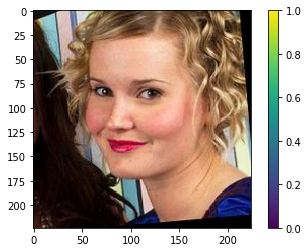

Idade 94


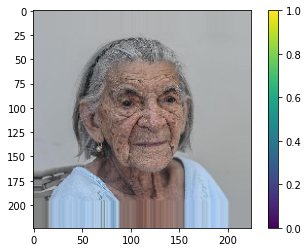

Idade 30


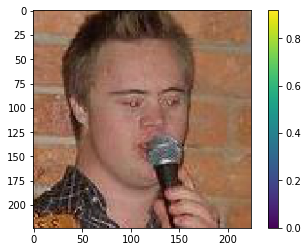

Idade 16


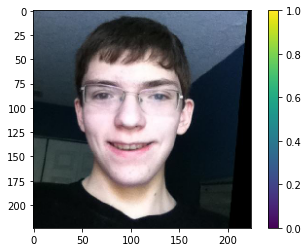

Idade 23


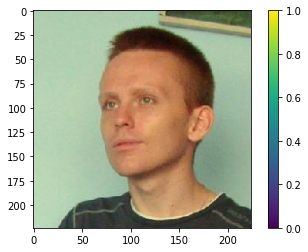

Idade 18


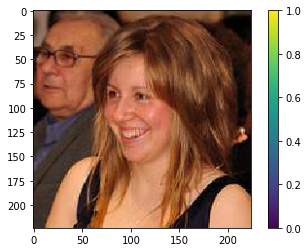

Idade 41


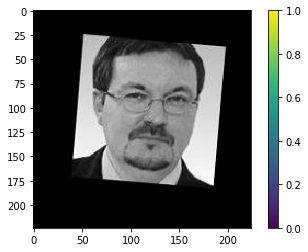

Idade 24


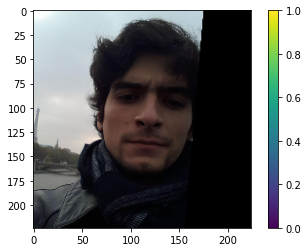

Idade 26


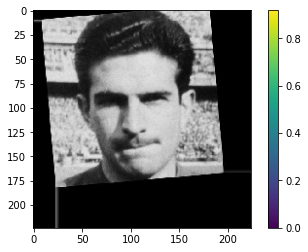

Idade 14


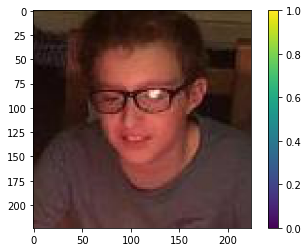

Idade 36


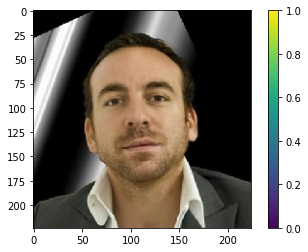

Idade 28


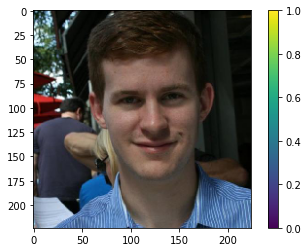

Idade 78


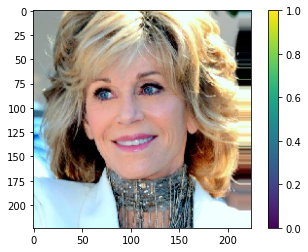

Idade 13


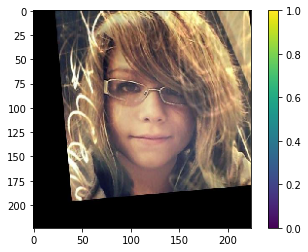

In [9]:
for i in range(0,32):
    print('Idade',target[i])
    plt.imshow(features[i])
    plt.colorbar()
    plt.show()

### Conclusões

As imagens geradas estão de acordo com as idades rotuladas. Nosso conjunto de dados parece fazer sentido. Como citei anteriormente a maioria das pessoas tem idade de 18 a 40 anos. A idade média encontrada foi de 31,2 anos, a mínima 1 e máxima 100 anos.    

## Modelagem 

Defina as funções necessárias para treinar seu modelo na plataforma GPU e construa um único script contendo todas elas junto com a seção de inicialização.

Para facilitar essa tarefa, você pode defini-las neste notebook e executar um código pronto na próxima seção para compor o script automaticamente.
As definições abaixo também serão verificadas pelos revisores do projeto, para que possam entender como você construiu o modelo.

In [10]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [11]:
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    files = path+'final_files/' 
    
      
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1.0 / 255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=files,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 
    
    return train_gen_flow

In [12]:
def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    files = path+'final_files/' 
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1.0 / 255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=files,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 

    
    # coloque seu código aqui

    return test_gen_flow

In [13]:
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(
    optimizer=optimizer,
    loss='mean_absolute_error',
    metrics=['mae']) 

    return model

In [14]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
    
    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2)

    return model 

## Preparar o Script para a Execução na plataforma GPU

Dado que você definiu as funções necessárias, você pode compor um script para a plataforma GPU, baixá-lo através do menu "Arquivo|Abrir..." e carregá-lo posteriormente para execução na plataforma GPU.

Nota: O script também deve incluir a seção de inicialização. Um exemplo disso é mostrado abaixo.

In [15]:
# preparar um script para ser executado na plataforma GPU


init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

Coloque a saída da plataforma GPU como uma célula Markdown aqui.

2023-06-06 22:25:15.208552: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-06-06 22:25:15.210383: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-06-06 22:25:16.665343: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-06-06 22:25:16.690067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:16.690248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2023-06-06 22:25:16.690288: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-06 22:25:16.690340: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-06 22:25:16.692161: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-06-06 22:25:16.692498: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-06-06 22:25:16.695332: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-06-06 22:25:16.697177: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-06-06 22:25:16.697247: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-06-06 22:25:16.697344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:16.697609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:16.697785: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-06-06 22:25:16.698070: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-06-06 22:25:16.708731: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300010000 Hz
2023-06-06 22:25:16.709423: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3f39100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-06-06 22:25:16.709457: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-06-06 22:25:16.794883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:16.795182: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x384a0d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-06 22:25:16.795208: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-06-06 22:25:16.795482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:16.795703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2023-06-06 22:25:16.795747: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-06 22:25:16.795767: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-06 22:25:16.795796: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-06-06 22:25:16.795818: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-06-06 22:25:16.795837: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-06-06 22:25:16.795860: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-06-06 22:25:16.795872: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-06-06 22:25:16.795956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:16.796211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:16.796395: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-06-06 22:25:16.796430: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-06 22:25:17.072066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-06-06 22:25:17.072111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-06-06 22:25:17.072121: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-06-06 22:25:17.072326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:17.072550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:17.072721: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-06 22:25:17.072754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13128 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
10969088/94765736 [==>...........................] - ETA: 0s
24215552/94765736 [======>.......................] - ETA: 0s
37429248/94765736 [==========>...................] - ETA: 0s
50749440/94765736 [===============>..............] - ETA: 0s
63815680/94765736 [===================>..........] - ETA: 0s
76988416/94765736 [=======================>......] - ETA: 0s
90046464/94765736 [===========================>..] - ETA: 0s
94773248/94765736 [==============================] - 0s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/20
2023-06-06 22:25:28.256585: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-06 22:25:28.594563: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 61s - loss: 11.3572 - mae: 11.3577 - val_loss: 22.7880 - val_mae: 22.7908
Epoch 2/20
178/178 - 39s - loss: 6.8229 - mae: 6.8234 - val_loss: 18.6425 - val_mae: 18.6316
Epoch 3/20
178/178 - 38s - loss: 5.5088 - mae: 5.5091 - val_loss: 13.4421 - val_mae: 13.4206
Epoch 4/20
178/178 - 39s - loss: 4.7863 - mae: 4.7867 - val_loss: 8.5230 - val_mae: 8.4903
Epoch 5/20
178/178 - 39s - loss: 4.2095 - mae: 4.2096 - val_loss: 6.4047 - val_mae: 6.4135
Epoch 6/20
178/178 - 39s - loss: 3.8687 - mae: 3.8689 - val_loss: 6.6194 - val_mae: 6.6283
Epoch 7/20
178/178 - 39s - loss: 3.4416 - mae: 3.4419 - val_loss: 6.2371 - val_mae: 6.2485
Epoch 8/20
178/178 - 39s - loss: 3.1523 - mae: 3.1523 - val_loss: 7.4713 - val_mae: 7.4670
Epoch 9/20
178/178 - 39s - loss: 2.9199 - mae: 2.9200 - val_loss: 6.0796 - val_mae: 6.0863
Epoch 10/20
178/178 - 39s - loss: 2.6430 - mae: 2.6428 - val_loss: 6.4869 - val_mae: 6.4935
Epoch 11/20
178/178 - 39s - loss: 2.5083 - mae: 2.5084 - val_loss: 6.2883 - val_mae: 6.3065
Epoch 12/20
178/178 - 38s - loss: 2.3915 - mae: 2.3915 - val_loss: 6.2929 - val_mae: 6.2992
Epoch 13/20
178/178 - 38s - loss: 2.3075 - mae: 2.3076 - val_loss: 5.9532 - val_mae: 5.9739
Epoch 14/20
178/178 - 38s - loss: 2.2367 - mae: 2.2367 - val_loss: 5.9462 - val_mae: 5.9700
Epoch 15/20
178/178 - 38s - loss: 2.1290 - mae: 2.1289 - val_loss: 5.9529 - val_mae: 5.9618
Epoch 16/20
178/178 - 39s - loss: 2.0458 - mae: 2.0459 - val_loss: 6.2146 - val_mae: 6.2325
Epoch 17/20
178/178 - 39s - loss: 2.0006 - mae: 2.0006 - val_loss: 6.2631 - val_mae: 6.2719
Epoch 18/20
178/178 - 38s - loss: 2.0113 - mae: 2.0114 - val_loss: 5.9282 - val_mae: 5.9474
Epoch 19/20
178/178 - 39s - loss: 1.8955 - mae: 1.8954 - val_loss: 5.8658 - val_mae: 5.8761
Epoch 20/20
178/178 - 39s - loss: 1.8835 - mae: 1.8832 - val_loss: 5.9530 - val_mae: 5.9595
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 5.9530 - mae: 5.9595
Test MAE: 5.9595
2023-06-06 22:25:15.208552: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-06-06 22:25:15.210383: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-06-06 22:25:16.665343: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-06-06 22:25:16.690067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:16.690248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2023-06-06 22:25:16.690288: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-06 22:25:16.690340: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-06 22:25:16.692161: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-06-06 22:25:16.692498: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-06-06 22:25:16.695332: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-06-06 22:25:16.697177: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-06-06 22:25:16.697247: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-06-06 22:25:16.697344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:16.697609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:16.697785: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-06-06 22:25:16.698070: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-06-06 22:25:16.708731: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300010000 Hz
2023-06-06 22:25:16.709423: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3f39100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-06-06 22:25:16.709457: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-06-06 22:25:16.794883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:16.795182: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x384a0d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-06 22:25:16.795208: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-06-06 22:25:16.795482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:16.795703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2023-06-06 22:25:16.795747: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-06 22:25:16.795767: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-06 22:25:16.795796: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-06-06 22:25:16.795818: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-06-06 22:25:16.795837: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-06-06 22:25:16.795860: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-06-06 22:25:16.795872: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-06-06 22:25:16.795956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:16.796211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:16.796395: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-06-06 22:25:16.796430: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-06 22:25:17.072066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-06-06 22:25:17.072111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-06-06 22:25:17.072121: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-06-06 22:25:17.072326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:17.072550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 22:25:17.072721: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-06 22:25:17.072754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13128 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
10969088/94765736 [==>...........................] - ETA: 0s
24215552/94765736 [======>.......................] - ETA: 0s
37429248/94765736 [==========>...................] - ETA: 0s
50749440/94765736 [===============>..............] - ETA: 0s
63815680/94765736 [===================>..........] - ETA: 0s
76988416/94765736 [=======================>......] - ETA: 0s
90046464/94765736 [===========================>..] - ETA: 0s
94773248/94765736 [==============================] - 0s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/20
2023-06-06 22:25:28.256585: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-06 22:25:28.594563: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 61s - loss: 11.3572 - mae: 11.3577 - val_loss: 22.7880 - val_mae: 22.7908
Epoch 2/20
178/178 - 39s - loss: 6.8229 - mae: 6.8234 - val_loss: 18.6425 - val_mae: 18.6316
Epoch 3/20
178/178 - 38s - loss: 5.5088 - mae: 5.5091 - val_loss: 13.4421 - val_mae: 13.4206
Epoch 4/20
178/178 - 39s - loss: 4.7863 - mae: 4.7867 - val_loss: 8.5230 - val_mae: 8.4903
Epoch 5/20
178/178 - 39s - loss: 4.2095 - mae: 4.2096 - val_loss: 6.4047 - val_mae: 6.4135
Epoch 6/20
178/178 - 39s - loss: 3.8687 - mae: 3.8689 - val_loss: 6.6194 - val_mae: 6.6283
Epoch 7/20
178/178 - 39s - loss: 3.4416 - mae: 3.4419 - val_loss: 6.2371 - val_mae: 6.2485
Epoch 8/20
178/178 - 39s - loss: 3.1523 - mae: 3.1523 - val_loss: 7.4713 - val_mae: 7.4670
Epoch 9/20
178/178 - 39s - loss: 2.9199 - mae: 2.9200 - val_loss: 6.0796 - val_mae: 6.0863
Epoch 10/20
178/178 - 39s - loss: 2.6430 - mae: 2.6428 - val_loss: 6.4869 - val_mae: 6.4935
Epoch 11/20
178/178 - 39s - loss: 2.5083 - mae: 2.5084 - val_loss: 6.2883 - val_mae: 6.3065
Epoch 12/20
178/178 - 38s - loss: 2.3915 - mae: 2.3915 - val_loss: 6.2929 - val_mae: 6.2992
Epoch 13/20
178/178 - 38s - loss: 2.3075 - mae: 2.3076 - val_loss: 5.9532 - val_mae: 5.9739
Epoch 14/20
178/178 - 38s - loss: 2.2367 - mae: 2.2367 - val_loss: 5.9462 - val_mae: 5.9700
Epoch 15/20
178/178 - 38s - loss: 2.1290 - mae: 2.1289 - val_loss: 5.9529 - val_mae: 5.9618
Epoch 16/20
178/178 - 39s - loss: 2.0458 - mae: 2.0459 - val_loss: 6.2146 - val_mae: 6.2325
Epoch 17/20
178/178 - 39s - loss: 2.0006 - mae: 2.0006 - val_loss: 6.2631 - val_mae: 6.2719
Epoch 18/20
178/178 - 38s - loss: 2.0113 - mae: 2.0114 - val_loss: 5.9282 - val_mae: 5.9474
Epoch 19/20
178/178 - 39s - loss: 1.8955 - mae: 1.8954 - val_loss: 5.8658 - val_mae: 5.8761
Epoch 20/20
178/178 - 39s - loss: 1.8835 - mae: 1.8832 - val_loss: 5.9530 - val_mae: 5.9595
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 5.9530 - mae: 5.9595
Test MAE: 5.9595





## Conclusão

Após treinar o modelo obtive um valor de EAM de 5.95, abaixo dos 8 requeridos pelo projeto. Portanto, o modelo escolhido foi excelente em prever a idade das pessoas através de imagens. 

Escolhi usar a arquitetura de rede REsNet50 com função de ativação ReLU, já que deveria haver apenas um neurônio na camada de saída. Além disso, a função ReLu não altera os números positivos e zera todos os negativos, o que faz todo sentido, porque não pode haver números menores do que zero quando estamos falando de idades. 

Como tratava-se de uma tarefa de regressão escolhi o erro absoluto médio na função de perda e na métrica de avaliação.  Creio que a escolha do algoritmo Adam com taxa de aprendizado de 0.0001 tenha sido fundamental para atingir o valor baixo de EAM.     